# Pyspark house prices prediction 🏚

В рамках данного проекта требуется проанализировать данные о жилье в Калифорнии.

Данные, которые мы будем анализировать, были собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.

**Содержание**<a id='toc0_'></a>    
1. [Подготовка     ](#toc1_)    
1.1. [Библиотеки     ](#toc1_1_)    
1.2. [Конфигурация     ](#toc1_2_)    
1.3. [Сервисные функции     ](#toc1_3_)    
2. [Данные     ](#toc2_)    
2.1. [Загрузка     ](#toc2_1_)    
2.2. [Проверка типов данных     ](#toc2_2_)    
2.3. [Обработка дубликатов     ](#toc2_3_)    
2.4. [Проверка пропусков     ](#toc2_4_)    
2.5. [Изучение данных     ](#toc2_5_)    
2.6. [Разделение данных](#toc2_6_)    
2.7. [Пайплайн](#toc2_7_)    
3. [Модель A1 (все данные)     ](#toc3_)    
3.1. [Обучение   ](#toc3_1_)    
3.2. [Предсказание    ](#toc3_2_)    
3.3. [Оценка качества   ](#toc3_3_)    
3.4. [Важность признаков  ](#toc3_4_)    
4. [Модель B1 (только числовые переменные)   ](#toc4_)    
4.1. [Обучение   ](#toc4_1_)    
4.2. [Предсказание   ](#toc4_2_)    
4.3. [Оценка качества   ](#toc4_3_)    
4.4. [Важность признаков ](#toc4_4_)    
5. [Улучшение моделей   ](#toc5_)    
5.1. [Подготовка ](#toc5_1_)    
5.2. [Модель А2 ](#toc5_2_)    
5.3. [Модель B2 ](#toc5_3_)    
6. [Подбор гиперпараметров ](#toc6_)    
6.1. [Модель А3 ](#toc6_1_)    
6.2. [Модель B3 ](#toc6_2_)    
7. [Общий вывод   ](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка      [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки      [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [ ]:
%pip install --upgrade -q pyspark
%pip install --upgrade -q pandas
%pip install --force-reinstall -v "numpy==1.26.4"

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline

In [4]:
pyspark_version = pyspark.__version__
pyspark_version

'3.5.3'

In [5]:
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder as OHE
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OHE

### 1.2. <a id='toc1_2_'></a>Конфигурация      [&#8593;](#toc0_)

In [6]:
RANDOM_SEED = 27

### 1.3. <a id='toc1_3_'></a>Сервисные функции      [&#8593;](#toc0_)

In [7]:
def print_table_about_nans(df: pyspark.sql.dataframe.DataFrame) -> None:
    display(df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T.sort_values(0))

In [8]:
def fill_missing_with_median_by_categories(
    df: pyspark.sql.dataframe.DataFrame,
    col_to_fill: str,
    category_col: str
    ) -> pyspark.sql.dataframe.DataFrame:

    # Вычисляем медиану для каждого значения категории
    median_df = df.groupBy(category_col).agg(
        F.percentile_approx(F.col(col_to_fill), 0.5).alias('median_value')
    )

    # Объединяем медианные значения с исходным DataFrame
    df_with_median = df.join(median_df, on=category_col, how='left')

    # Заполняем пропуски медианными значениями
    df_filled = df_with_median.withColumn(
        col_to_fill,
        F.expr(f'coalesce({col_to_fill}, median_value)')
    ).drop('median_value')

    return df_filled

In [9]:
def print_metrics(predictions: pyspark.sql.dataframe.DataFrame) -> None:
    rmse = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictions)
    mae = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictions)
    r2 = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictions)

    df = pd.DataFrame([rmse, mae, r2], index=['rmse', 'mae', 'r2'], columns=['metric_value'])
    display(df)

In [10]:
def plot_feature_importances(columns: list[str], coefficients: list[float]) -> None:
    feature_importance = np.array(sorted(list(zip(columns, map(abs, coefficients))), key=lambda x: x[1], reverse=True))
    feature_importance = pd.DataFrame(feature_importance[:, 1], index=feature_importance[:, 0], columns=['importance'])
    feature_importance['importance'] = feature_importance['importance'].astype(np.float32)

    feature_importance = feature_importance.sort_values('importance')
    ax = feature_importance.plot(kind='barh', color='skyblue', legend=False, figsize=(10, 5))
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    for i, v in enumerate(feature_importance['importance']):
        ax.text(v, i, f'{v:.2f}', va='center', ha='left', color='black')

    plt.tight_layout()
    plt.show()

In [11]:
def make_pipeline(cat_cols: list[str], num_cols: list[str], model=None) -> Pipeline:
    stages = [
        # categorical columns
        StringIndexer(inputCols=cat_cols, outputCols=[c + '_idx' for c in cat_cols], handleInvalid='keep'),
        OHE(inputCols=[c + '_idx' for c in cat_cols], outputCols=[c + '_ohe' for c in cat_cols]),
        VectorAssembler(inputCols=[c + '_ohe' for c in cat_cols], outputCol='cat_features'),

        # numeric columns
        VectorAssembler(inputCols=num_cols, outputCol='num_features'),
        StandardScaler(inputCol='num_features', outputCol='num_features_scaled'),

        # final assembling
        VectorAssembler(inputCols=['cat_features', 'num_features_scaled'], outputCol='features')
    ]

    if model is not None:
        stages.append(model)

    pipeline = Pipeline(stages=stages)
    return pipeline

## 2. <a id='toc2_'></a>Данные      [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка      [&#8593;](#toc0_)

In [12]:
spark = SparkSession.builder \
    .master('local') \
    .appName('Pyspark house prices prediction') \
    .getOrCreate()

clear_output()

In [13]:
df = spark.read.option('header', 'true').csv('./data/housing.csv', inferSchema=True)

In [14]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

### 2.2. <a id='toc2_2_'></a>Проверка типов данных      [&#8593;](#toc0_)

In [15]:
print(pd.DataFrame(df.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


Типы данных во всех столбцах корректны.

### 2.3. <a id='toc2_3_'></a>Обработка дубликатов      [&#8593;](#toc0_)

In [16]:
duplicates_num = df.count() - df.dropDuplicates().count()
duplicates_num

0

Полных дубликатов не обнаружено.

### 2.4. <a id='toc2_4_'></a>Проверка пропусков      [&#8593;](#toc0_)

In [17]:
print_table_about_nans(df)

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0
total_bedrooms,207


In [18]:
207 / df.count() * 100

1.002906976744186

Всего один столбец (`total_bedrooms`) содержит пропуски. Причем процент пропусков крайне незначительный - `1%`. Заполним пропуски:

In [19]:
df = fill_missing_with_median_by_categories(df, 'total_bedrooms', 'ocean_proximity')

Проверим, что пропусков больше нет:

In [20]:
print_table_about_nans(df)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=27906Kb max_used=27906Kb free=103165Kb
 bounds [0x000000010a1f8000, 0x000000010bd68000, 0x00000001121f8000]
 total_blobs=10367 nmethods=9411 adapters=865
 compilation: disabled (not enough contiguous free space left)


,0
ocean_proximity,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


Все пропуски были заполнены медианным значением по категориям.

### 2.5. <a id='toc2_5_'></a>Изучение данных      [&#8593;](#toc0_)

In [21]:
df.describe().toPandas().set_index('summary').T

24/10/18 11:53:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary,count,mean,stddev,min,max
ocean_proximity,20640,None,None,<1H OCEAN,NEAR OCEAN
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20640,536.8512596899225,419.39102897442507,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


In [22]:
target = 'median_house_value'

cat_cols = ['ocean_proximity']
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

### 2.6. <a id='toc2_6_'></a>Разделение данных [&#8593;](#toc0_)

In [23]:
train, test = df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)
train.count(), test.count()

(16442, 4198)

### 2.7. <a id='toc2_7_'></a>Пайплайн [&#8593;](#toc0_)

In [24]:
pipeline = make_pipeline(cat_cols, num_cols)
pipeline_model = pipeline.fit(train)

train_transformed = pipeline_model.transform(train)
test_transformed = pipeline_model.transform(test)

In [25]:
train_transformed.show(3)

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_idx|ocean_proximity_ohe| cat_features|        num_features| num_features_scaled|            features|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+
|      <1H OCEAN|  -124.13|   40.55|              38.0|      544.0|         438.0|     240.0|      91.0|         3.25|           94800.0|                0.0|      (5,[0],[1.0])|(5,[0],[1.0])|[-124.13,40.55,38...|[-62.067972962425...|[1

## 3. <a id='toc3_'></a>Модель A1 (все данные)      [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Обучение    [&#8593;](#toc0_)

In [26]:
lr = LinearRegression(featuresCol='features', labelCol=target)
model = lr.fit(train_transformed)

24/10/18 11:53:14 WARN Instrumentation: [e96be769] regParam is zero, which might cause numerical instability and overfitting.
24/10/18 11:53:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/18 11:53:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### 3.2. <a id='toc3_2_'></a>Предсказание     [&#8593;](#toc0_)

In [27]:
preds = model.transform(test_transformed)

In [28]:
preds.show(3)

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_idx|ocean_proximity_ohe| cat_features|        num_features| num_features_scaled|            features|        prediction|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|      <1H OCEAN|  -124.14|   40.57|              29.0|     2864.0|         600.0|    1314.0|     562.0|       2.1354|           75100.0|                0.0|      (5,[0],[1.0])|(

In [29]:
preds.select('median_house_value', 'prediction').show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           75100.0|159999.66518781334|
|           92500.0|165264.97846042737|
|           97300.0| 165966.5007095486|
|           92600.0| 149791.7971461378|
|          106300.0|175387.52892674878|
+------------------+------------------+
only showing top 5 rows



Кажется, что модель не очень хорошо справляется со своей задачей. Проверим метрики.

### 3.3. <a id='toc3_3_'></a>Оценка качества    [&#8593;](#toc0_)

In [30]:
print_metrics(preds)

,metric_value
rmse,65996.753554
mae,48577.024037
r2,0.659029


### 3.4. <a id='toc3_4_'></a>Важность признаков   [&#8593;](#toc0_)

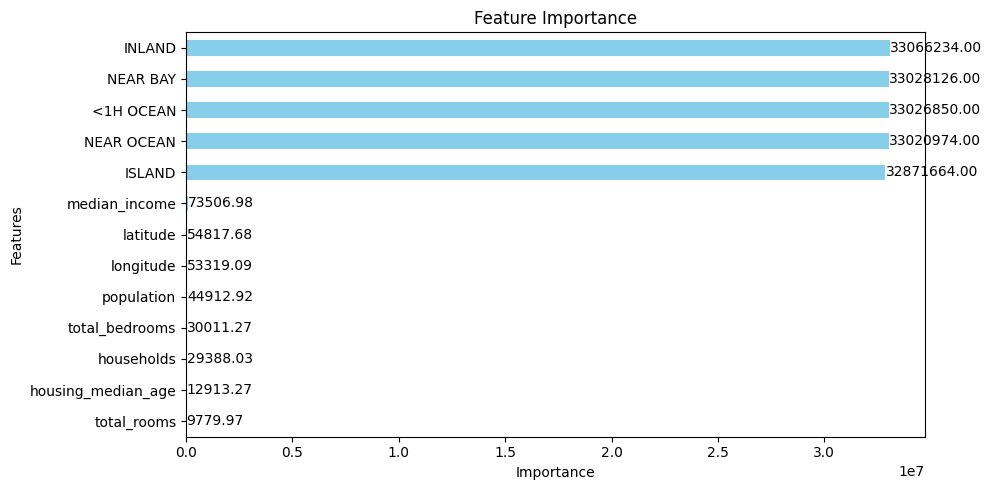

In [31]:
indexer_model = pipeline_model.stages[0]
columns = indexer_model.labels + num_cols
plot_feature_importances(columns, model.coefficients)

## 4. <a id='toc4_'></a>Модель B1 (только числовые переменные)    [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Обучение    [&#8593;](#toc0_)

In [32]:
lr_b = LinearRegression(featuresCol='num_features_scaled', labelCol=target)
model_b = lr_b.fit(train_transformed)

24/10/18 11:53:17 WARN Instrumentation: [aef70666] regParam is zero, which might cause numerical instability and overfitting.


### 4.2. <a id='toc4_2_'></a>Предсказание    [&#8593;](#toc0_)

In [33]:
preds_b = model_b.transform(test_transformed)

In [34]:
preds_b.show(3)

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_idx|ocean_proximity_ohe| cat_features|        num_features| num_features_scaled|            features|        prediction|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|      <1H OCEAN|  -124.14|   40.57|              29.0|     2864.0|         600.0|    1314.0|     562.0|       2.1354|           75100.0|                0.0|      (5,[0],[1.0])|(

Проверим метрики.

### 4.3. <a id='toc4_3_'></a>Оценка качества    [&#8593;](#toc0_)

In [35]:
print_metrics(preds_b)

,metric_value
rmse,66945.516942
mae,49610.139468
r2,0.649155


Метрики оказались самую малость, но хуже, чем в случае А.

### 4.4. <a id='toc4_4_'></a>Важность признаков  [&#8593;](#toc0_)

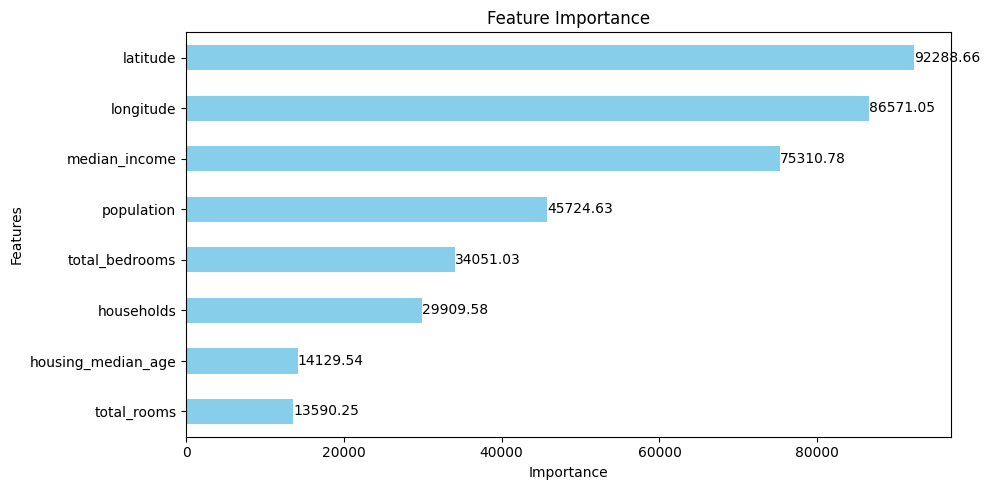

In [36]:
plot_feature_importances(num_cols, model_b.coefficients)

## 5. <a id='toc5_'></a>Улучшение моделей    [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Подготовка  [&#8593;](#toc0_)

Попробуем добавить несколько новых признаков.

In [37]:
def generate_features(df) -> pyspark.sql.dataframe.DataFrame:
    return df \
        .withColumn('rooms_per_household', F.col('total_rooms') / F.col('households')) \
        .withColumn('population_in_household', F.col('population') / F.col('households')) \
        .withColumn('bedroom_part', F.col('total_bedrooms') / F.col('total_rooms'))

In [38]:
train = generate_features(train)
test = generate_features(test)

In [39]:
train.show(3)

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-----------------------+-------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|rooms_per_household|population_in_household|       bedroom_part|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-----------------------+-------------------+
|      <1H OCEAN|  -124.13|   40.55|              38.0|      544.0|         438.0|     240.0|      91.0|         3.25|           94800.0|  5.978021978021978|     2.6373626373626373| 0.8051470588235294|
|      <1H OCEAN|  -124.11|   40.57|              33.0|     1348.0|         234.0|     573.0|     236.0|       2.4896|           74100.0|  5.711864406779661|     2.4279661016949152|0.173590504

In [40]:
cat_cols = ['ocean_proximity']
num_cols = ['longitude',
            'latitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'rooms_per_household',
            'population_in_household',
            'bedroom_part'
        ]

In [41]:
pipeline = make_pipeline(cat_cols, num_cols)
pipeline_model = pipeline.fit(train)

train_transformed = pipeline_model.transform(train)
test_transformed = pipeline_model.transform(test)

In [42]:
train_transformed.show(3)

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-----------------------+-------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|rooms_per_household|population_in_household|       bedroom_part|ocean_proximity_idx|ocean_proximity_ohe| cat_features|        num_features| num_features_scaled|            features|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-------------------+-----------------------+-------------------+-------------------+-------------------+-------------+--------------------+--------------------+--------------------+
|      <1H OCEAN|  -124.13|   40.55|       

### 5.2. <a id='toc5_2_'></a>Модель А2  [&#8593;](#toc0_)

In [43]:
lr = LinearRegression(featuresCol='features', labelCol=target)
model = lr.fit(train_transformed)
preds = model.transform(test_transformed)
print_metrics(preds)

24/10/18 11:53:21 WARN Instrumentation: [ead27acd] regParam is zero, which might cause numerical instability and overfitting.


,metric_value
rmse,66078.910511
mae,48329.892984
r2,0.658179


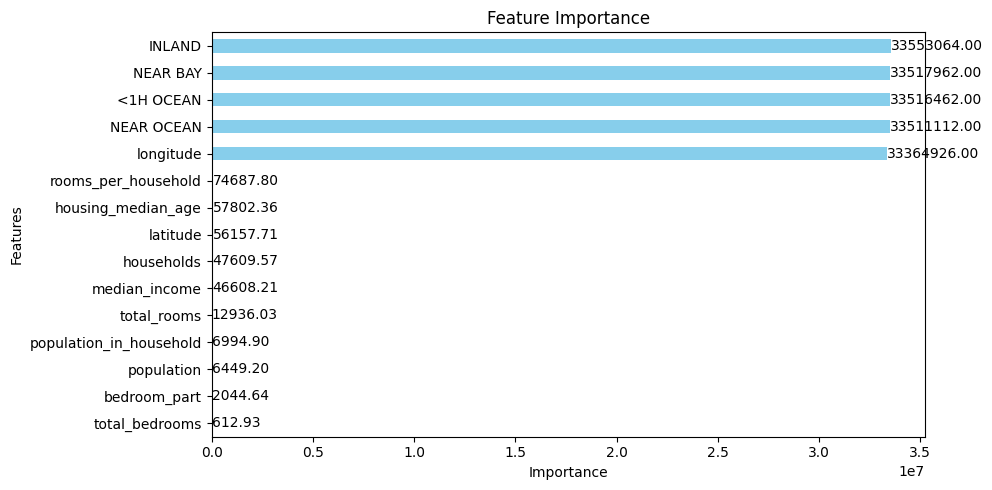

In [44]:
indexer_model = pipeline_model.stages[0]
columns = indexer_model.labels[:-1] + num_cols
plot_feature_importances(columns, model.coefficients)

### 5.3. <a id='toc5_3_'></a>Модель B2  [&#8593;](#toc0_)

In [45]:
lr = LinearRegression(featuresCol='num_features_scaled', labelCol=target)
model = lr.fit(train_transformed)
preds = model.transform(test_transformed)
print_metrics(preds)

24/10/18 11:53:22 WARN Instrumentation: [5f46f01c] regParam is zero, which might cause numerical instability and overfitting.


,metric_value
rmse,67008.291415
mae,49206.461153
r2,0.648497


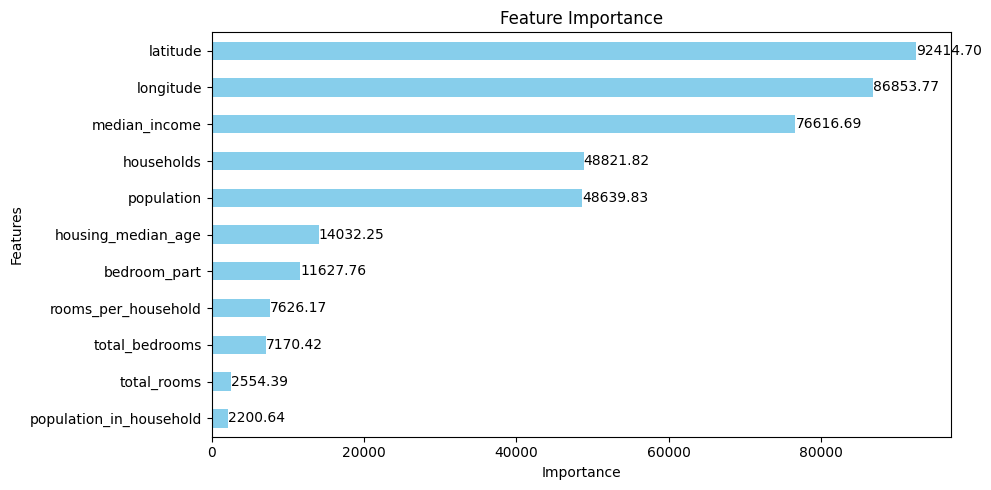

In [46]:
plot_feature_importances(num_cols, model.coefficients)

В данном случае результаты лишь немного лучше, чем до добавления новых признаков. И также, как и в первом случае, модель, которая учитывает категориальные признаки работает лучше, чем та, что не учитывает их.

## 6. <a id='toc6_'></a>Подбор гиперпараметров  [&#8593;](#toc0_)

### 6.1. <a id='toc6_1_'></a>Модель А3  [&#8593;](#toc0_)

In [47]:
lr = LinearRegression(featuresCol='features', labelCol=target)

In [48]:
pipeline_with_model = make_pipeline(cat_cols, num_cols, lr)

In [49]:
paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 50, 100, 200]) \
        .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .addGrid(lr.tol, [1e-6, 1e-4, 1e-2]) \
        .build()

In [50]:
tvs = TrainValidationSplit(estimator=pipeline_with_model,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol='median_house_value', metricName='rmse'),
                           trainRatio=0.8)

In [51]:
model = tvs.fit(train)

In [52]:
bestModel = model.bestModel

In [53]:
preds = bestModel.transform(test)

In [54]:
print_metrics(preds)

,metric_value
rmse,66082.065462
mae,48332.468906
r2,0.658147


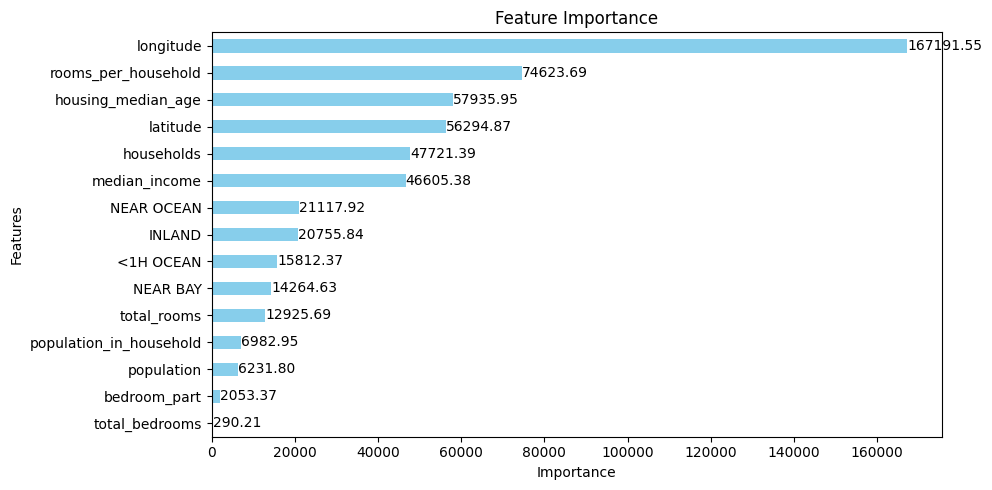

In [55]:
indexer_model = bestModel.stages[0]
columns = indexer_model.labels[:-1] + num_cols
plot_feature_importances(columns, bestModel.stages[-1].coefficients)

### 6.2. <a id='toc6_2_'></a>Модель B3  [&#8593;](#toc0_)

In [56]:
lr = LinearRegression(featuresCol='num_features_scaled', labelCol=target)

In [57]:
pipeline_with_model = make_pipeline(cat_cols, num_cols, lr)

In [58]:
tvs = TrainValidationSplit(estimator=pipeline_with_model,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol='median_house_value', metricName='rmse'),
                           trainRatio=0.8)

In [59]:
model = tvs.fit(train)
clear_output()

In [60]:
bestModel = model.bestModel

In [61]:
preds = bestModel.transform(test)

In [62]:
print_metrics(preds)

,metric_value
rmse,67008.291415
mae,49206.461153
r2,0.648497


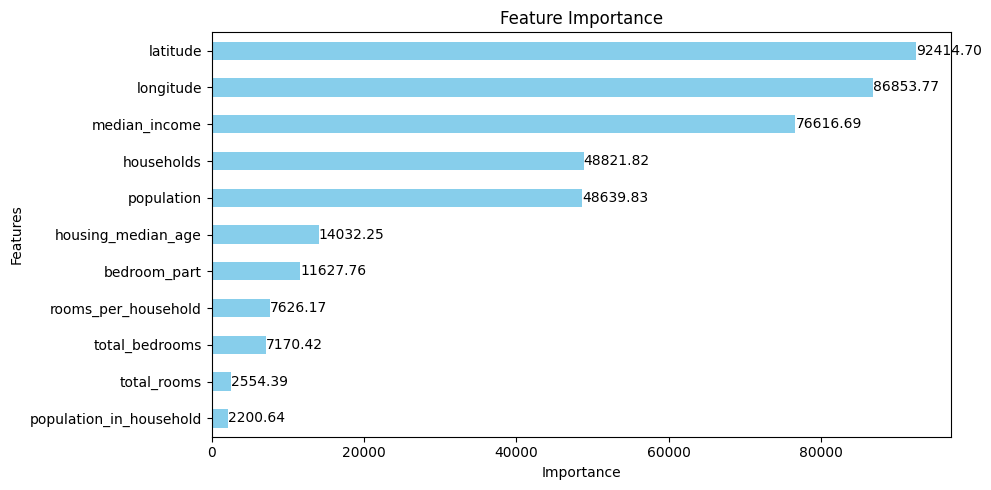

In [63]:
plot_feature_importances(num_cols, bestModel.stages[-1].coefficients)

---

In [64]:
spark.stop()

## 7. <a id='toc7_'></a>Общий вывод    [&#8593;](#toc0_)

В рамках проекта велась работа с датасетом по жилью в Калифорнии. Датасет был загружен в PySpark DataFrame и исследован:
- Типы данных столбцов были определены корректно
- Полных дубликатов не было
- Пропуски были только в столбце `total_bedrooms` (около 1%) и были заполнены медианным значением по категории `ocean_proximity`.

Далее был этап обработки:
- Категориальные переменные (`ocean_proximity`) были преобразованы с помощью `StringIndexer` и закодированы через `OneHotEncoder`
- Числовые переменные были обработаны с помощью `StandardScaler`
- Все переменные были соединены в один столбец через `VectorAssembler`.

Было протестированы 2 типа моделей:  
**А** тип: использовались все признаки  
**B** тип: использовались только числовые признаки (то есть без категориальных)

Сначала (модели А1 И В1) использовался изначальный набор признаков. На 2 этапе (А2 и В2) были сгенерированы 3 дополнительных признака. На 3 этапе также использовался подбор гиперпараметров.

В результате получились следующие метрики:

|      | A1      | B1      | A2      | B2      | A3      | B3      |
|------|---------|---------|---------|---------|---------|---------|
| RMSE | 65996.7 | 66945.5 | 66078.9 | 67008.3 | 66078.9 | 67008.3 |
| MAE  | 48577.0 | 49610   | 48329.9 | 49206.5 | 48329.9 | 49206.5 |
| R2   | 0.659   | 0.649   | 0.658   | 0.648   | 0.658   | 0.648   |

- Подбор гиперпараметров в данном случае не дал никаких улучшений (значения по умолчанию оказались самыми оптимальными).
- Добавление новых признаков почти не дало результатов: несколько уменьшились MAE и R2, но выросла RMSE.
- Модели А типа (все признаки) и В типа (без категориальных) показали примерно одинаковый результат. Модели А типа показывают чуть лучшие RMSE и MAE, но проигрывают в R2.